In [1]:
import pandas as pd

df = pd.read_pickle("df_reduced.pkl")
df.head()

,name,date,quantity,exposure,tracked_id,centered_traj,cluster_agg
0,balder,01062021-25,0,0.0,1.0,"[[-11.354838709677423, 2.516129032258064], [-1...",21
1,balder,01062021-25,0,0.0,3.0,"[[-32.243697478991606, -0.6134453781512619], [...",12
2,balder,01062021-25,0,0.0,4.0,"[[3.5581395348837077, 9.0], [3.558139534883707...",21
3,balder,01062021-25,0,0.0,6.0,"[[23.952941176470574, 1.7176470588235304], [22...",45
4,balder,01062021-25,0,0.0,7.0,"[[2.2413793103448256, -1.6896551724137936], [1...",11


In [2]:
import numpy as np
import pandas as pd
from numpy.fft import fft
from sklearn.cluster import KMeans
import ast

def fourier_descriptors(trajectory):
    # Assuming the trajectory is a list of [x, y] coordinates
    trajectory = np.array(trajectory)
    x = trajectory[:, 0]
    y = trajectory[:, 1]

    # Apply Fourier Transform
    fd_x = fft(x)
    fd_y = fft(y)

    # Combine the descriptors and return
    return np.concatenate([np.abs(fd_x), np.abs(fd_y)])

In [3]:
from scipy.interpolate import interp1d

def interpolate_trajectory(trajectory, num_points=50):
    # Assuming trajectory is a list of [x, y] coordinates
    trajectory = np.array(trajectory)
    x = trajectory[:, 0]
    y = trajectory[:, 1]

    # Create an interpolation function
    length = len(trajectory)
    f_x = interp1d(np.linspace(0, 1, length), x, kind='linear')
    f_y = interp1d(np.linspace(0, 1, length), y, kind='linear')

    # Interpolate to a common number of points
    new_x = f_x(np.linspace(0, 1, num_points))
    new_y = f_y(np.linspace(0, 1, num_points))

    return np.column_stack((new_x, new_y))

In [4]:
df['interpolated_traj'] = df['centered_traj'].apply(interpolate_trajectory)
df['fourier_descriptors'] = df['interpolated_traj'].apply(fourier_descriptors)

In [5]:
# Extracting the Fourier Descriptors as features for clustering
features = np.stack(df['fourier_descriptors'].values)

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

num_c = 5

# Optional: Normalize features
scaler = StandardScaler()
fd_normalized = scaler.fit_transform(features)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% of variance
fd_reduced = pca.fit_transform(fd_normalized)

# Apply Hierarchical Agglomerative Clustering
hac = AgglomerativeClustering(n_clusters=num_c)
cluster_labels = hac.fit_predict(fd_reduced)
df['HAC_cluster'] = cluster_labels

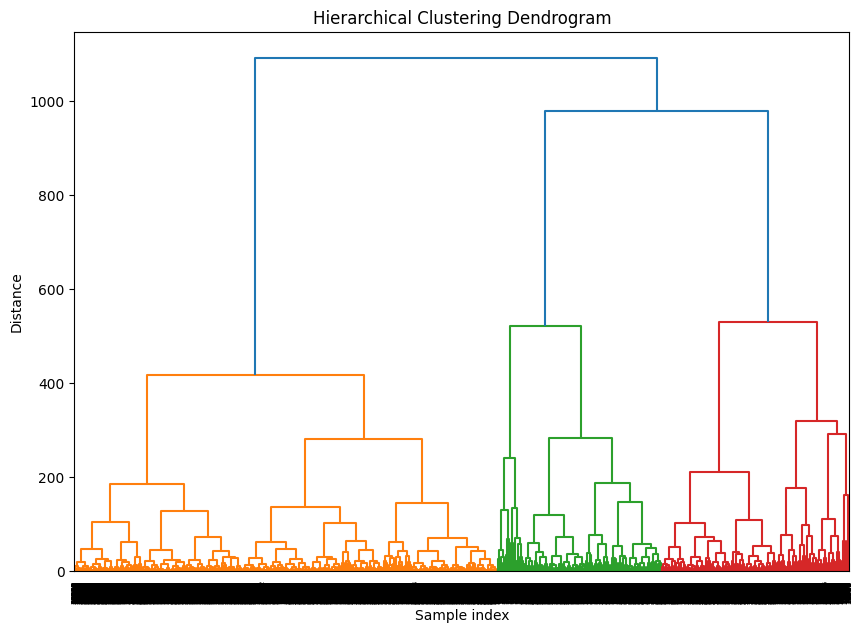

In [7]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Perform hierarchical clustering using 'linkage'
# The 'ward' method is often used for its good balance between speed and quality.
Z = linkage(fd_reduced, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()


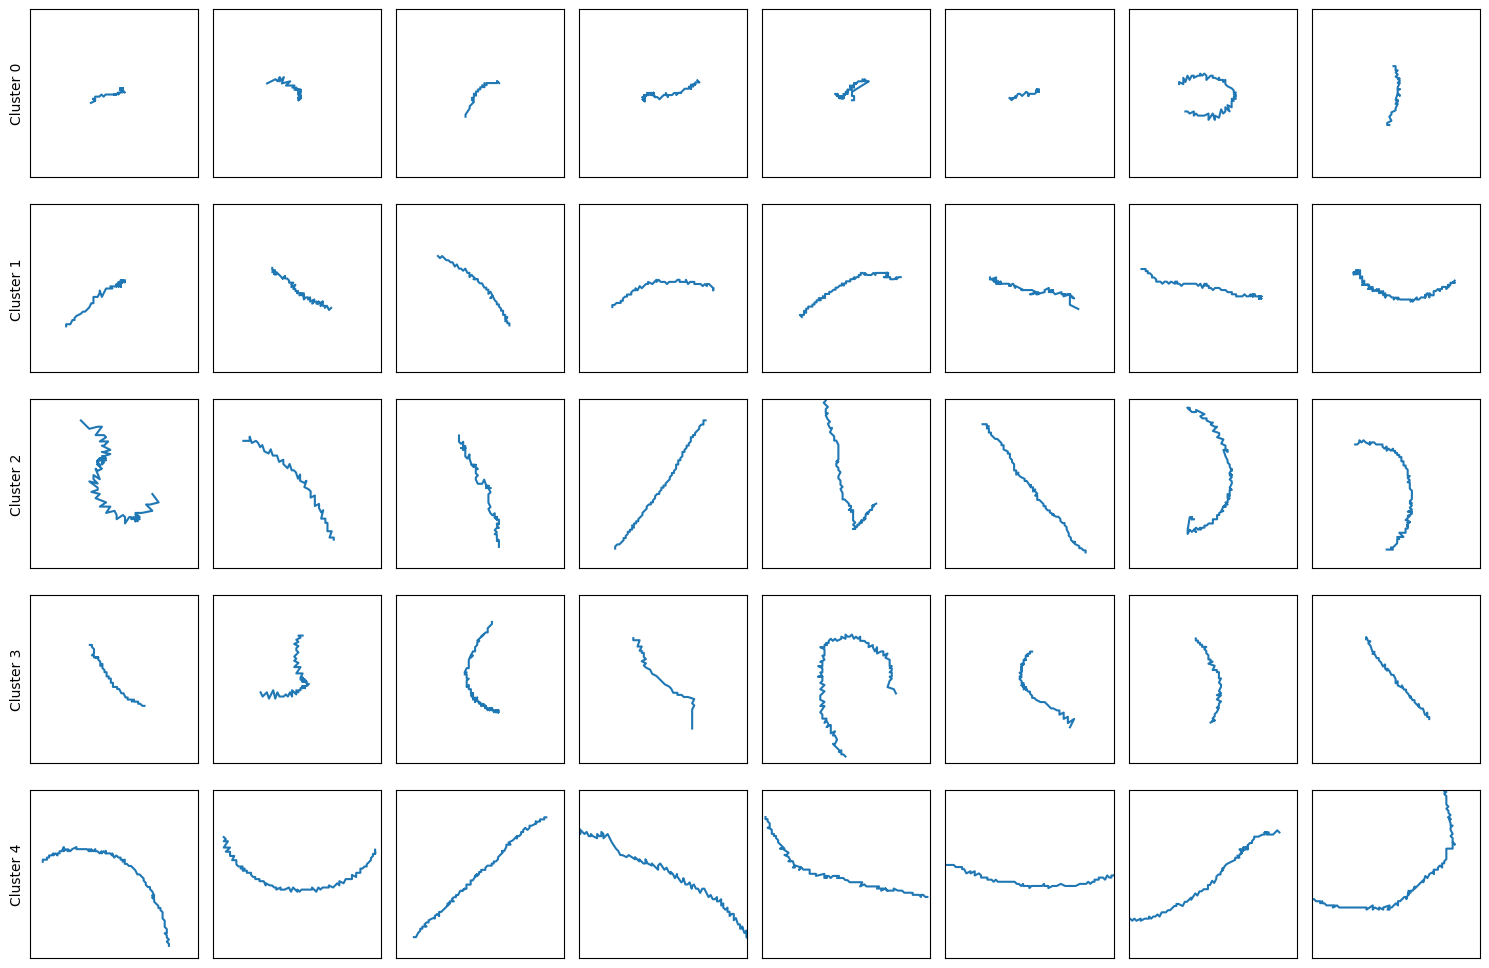

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast


n_samples = 8
# Create a figure with subplots
fig, axes = plt.subplots(num_c, n_samples, figsize=(15, 10))  # Adjust the size as needed

for i in range(num_c):
    # Select random samples from each cluster
    cluster_data = df[df['HAC_cluster'] == i].sample(n=n_samples, random_state=42)
    
    for j, (index, row) in enumerate(cluster_data.iterrows()):
        ax = axes[i][j]
        # Extract the centered trajectory
        traj_array = np.array(row['centered_traj'])
        # Plot the trajectory
        ax.plot(traj_array[:, 0], traj_array[:, 1])

        ax.set_xlim(-40, 40)
        ax.set_ylim(-40, 40)
        ax.set_aspect('equal', adjustable='box')

        # Optional: Hide x and y axis labels for clarity
        ax.set_xticks([])
        ax.set_yticks([])

    # Set y-axis label for each row
    axes[i][0].set_ylabel(f"Cluster {i}")

# Optional: adjust layout for better spacing
plt.tight_layout()
plt.show()

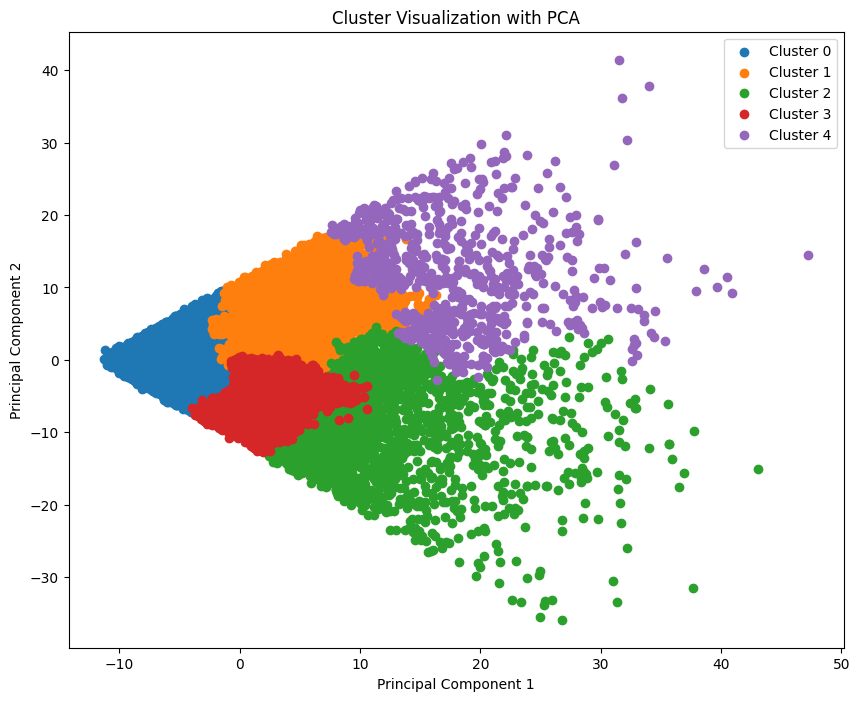

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming 'features' are your motility parameters
# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(fd_normalized)

# Plot
plt.figure(figsize=(10, 8))
for cluster in range(num_c):  
    cluster_data = reduced_features[df['HAC_cluster'] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}')

plt.title('Cluster Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


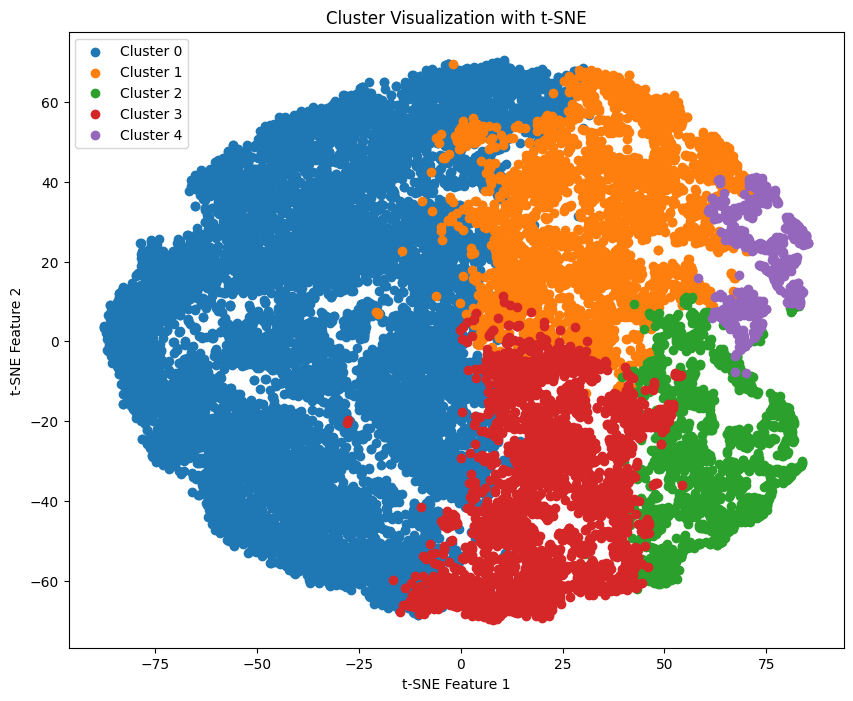

In [11]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming 'features' are your motility parameters
# Perform t-SNE to reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)  # random_state for reproducibility
reduced_features = tsne.fit_transform(fd_normalized)

# Plot
plt.figure(figsize=(10, 8))
for cluster in range(num_c):  # Assuming there are 4 clusters
    cluster_data = reduced_features[df['HAC_cluster'] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}')

plt.title('Cluster Visualization with t-SNE')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()
plt.show()


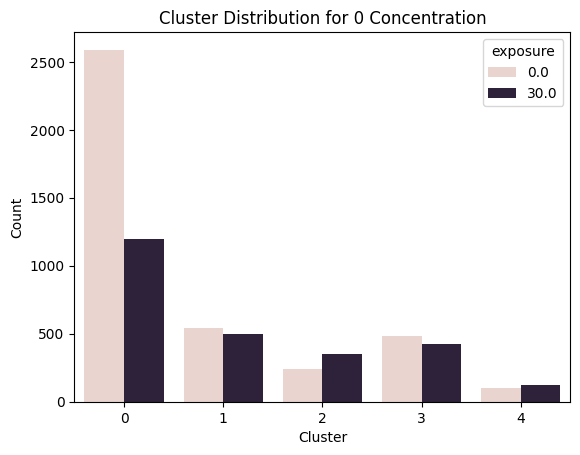

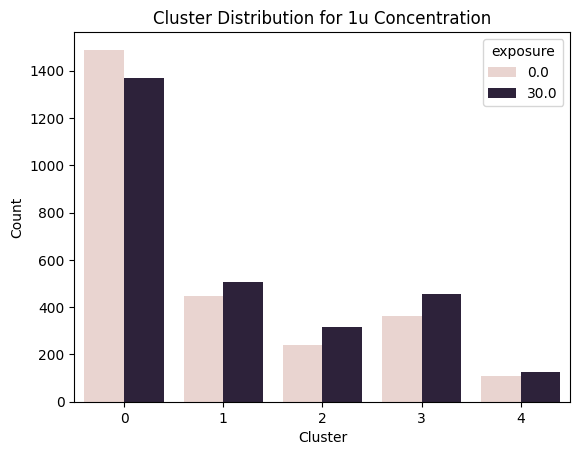

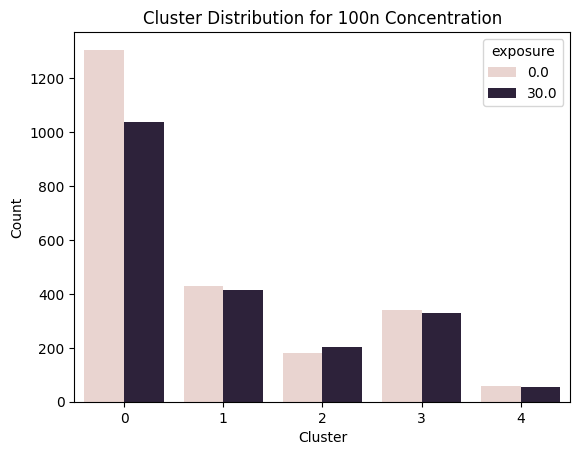

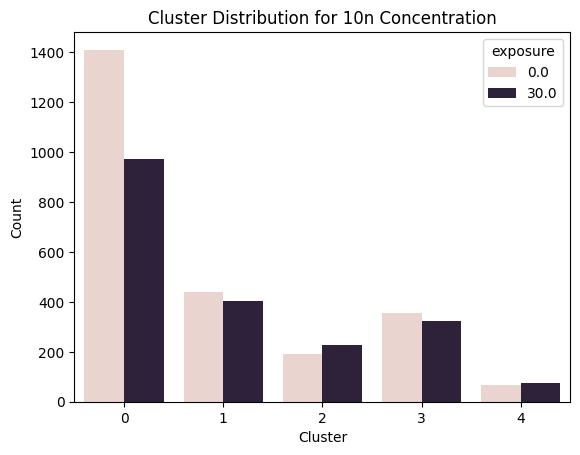

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Distribution of clusters at different time points for each concentration
def plot_cluster_distribution(df):
    for concentration in df['quantity'].unique():
        subset = df[df['quantity'] == concentration]
        sns.countplot(x='HAC_cluster', hue='exposure', data=subset)
        plt.title(f'Cluster Distribution for {concentration} Concentration')
        plt.xlabel('Cluster')
        plt.ylabel('Count')
        plt.show()

plot_cluster_distribution(df)

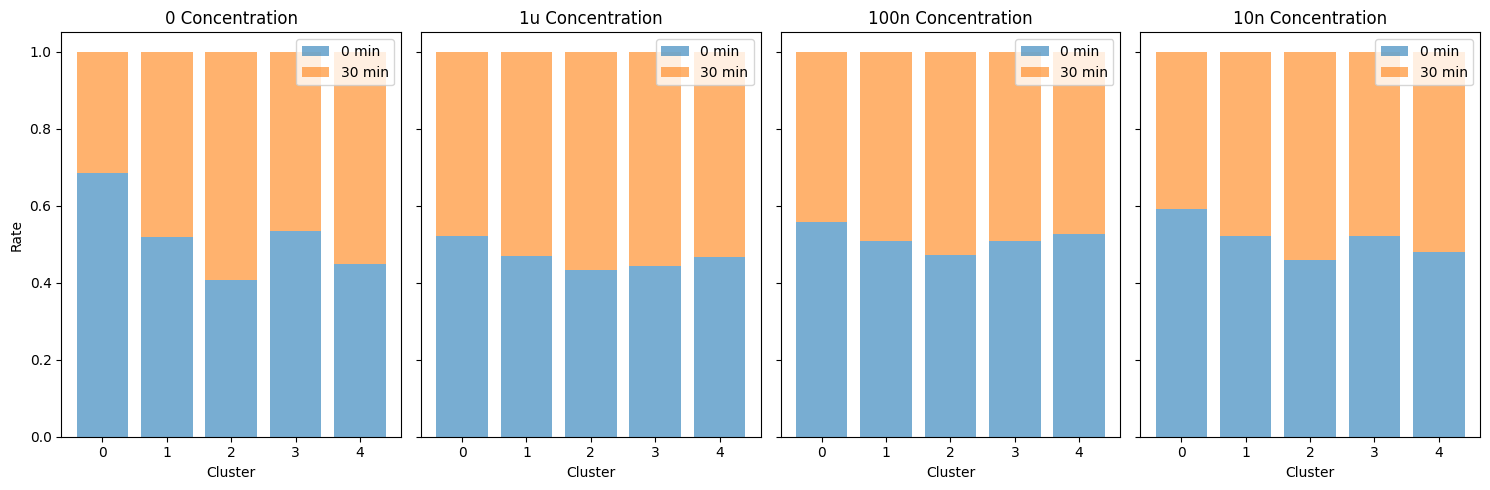

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot rate of elements in each cluster
def plot_cluster_rate(df, num_c):
    # Get unique concentrations
    concentrations = df['quantity'].unique()
    clusters = range(num_c)  # Assuming num_c is the number of clusters

    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(concentrations), figsize=(15, 5), sharey=True)

    for i, concentration in enumerate(concentrations):
        subset = df[df['quantity'] == concentration]
        total = subset.groupby(['HAC_cluster'])['exposure'].count()

        # Calculate rate (proportion) of elements in each cluster at 0 and 30 minutes
        rate_0 = subset[subset['exposure'] == 0].groupby(['HAC_cluster'])['exposure'].count() / total
        rate_30 = subset[subset['exposure'] == 30].groupby(['HAC_cluster'])['exposure'].count() / total

        # Create bar plot for each concentration
        axes[i].bar(clusters, rate_0, label='0 min', alpha=0.6)
        axes[i].bar(clusters, rate_30, bottom=rate_0, label='30 min', alpha=0.6)
        axes[i].set_title(f'{concentration} Concentration')
        axes[i].set_xlabel('Cluster')
        axes[i].set_ylabel('Rate' if i == 0 else '')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

plot_cluster_rate(df, num_c)  # Assuming num_c is the number of clusters


In [14]:
master_df = pd.read_pickle("/home/rodriguez/Documents/my_codes/trajectory/master_08052022.pkl")
motility_param = ['VCL', 'VAP', 'VSL', 'LIN', 'STR', 'WOB', 'BeatCross']
for param in motility_param:
    df[param] = master_df[param]
df.sample()

,name,date,quantity,exposure,tracked_id,centered_traj,cluster_agg,interpolated_traj,fourier_descriptors,HAC_cluster,VCL,VAP,VSL,LIN,STR,WOB,BeatCross
1066,balder,01062021-30,1u,0.0,163.0,"[[-10.14285714285711, -0.9747899159663689], [-...",35,"[[-10.14285714285711, -0.9747899159663689], [-...","[0.795918367348448, 243.96164537060014, 168.72...",0,60.731304,33.35835,24.152706,0.397698,0.724038,0.549278,35.892857


In [15]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# List of motility parameters
motility_parameters = ['VCL', 'VAP', 'VSL', 'LIN', 'STR', 'WOB', 'BeatCross']

# ANOVA for each motility parameter within each cluster
anova_results = {}
for cluster in df['HAC_cluster'].unique():
    cluster_data = df[df['HAC_cluster'] == cluster]
    anova_results_cluster = {}

    for param in motility_parameters:
        model = ols(f'{param} ~ C(quantity) * C(exposure)', data=cluster_data).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        anova_results_cluster[param] = anova_table

    anova_results[cluster] = anova_results_cluster

# Output ANOVA results
for cluster, results in anova_results.items():
    print(f'ANOVA results for Cluster {cluster}:')
    for param, result in results.items():
        print(f'ANOVA for {param}:')
        print(result)
        print()  # Adding a blank line for better readability

ANOVA results for Cluster 0:
ANOVA for VCL:
                               sum_sq       df           F        PR(>F)
C(quantity)              1.797368e+05      3.0   58.219101  2.423333e-37
C(exposure)              2.957062e+05      1.0  287.349324  1.136332e-63
C(quantity):C(exposure)  6.856361e+04      3.0   22.208652  2.474620e-14
Residual                 1.169244e+07  11362.0         NaN           NaN

ANOVA for VAP:
                               sum_sq       df          F        PR(>F)
C(quantity)              3.992263e+04      3.0  37.879586  2.385531e-24
C(exposure)              2.174998e+04      1.0  61.910780  3.919369e-15
C(quantity):C(exposure)  1.234956e+04      3.0  11.717572  1.160406e-07
Residual                 3.991604e+06  11362.0        NaN           NaN

ANOVA for VSL:
                               sum_sq       df          F    PR(>F)
C(quantity)              6.605455e+03      3.0   9.432303  0.000003
C(exposure)              3.852901e+03      1.0  16.505326  0.00

In [16]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from patsy.contrasts import Helmert

# List of motility parameters
motility_parameters = ['VCL', 'VAP', 'VSL', 'LIN', 'STR', 'WOB', 'BeatCross']

# ANOVA with Helmert contrasts for each motility parameter within each cluster
anova_results = {}
for cluster in df['HAC_cluster'].unique():
    cluster_data = df[df['HAC_cluster'] == cluster]
    anova_results_cluster = {}

    for param in motility_parameters:
        # Fitting the model with Helmert contrasts
        formula = f'{param} ~ C(quantity, Helmert()) * C(exposure)'
        model = ols(formula, data=cluster_data).fit()

        # Calculating ANOVA table with contrasts
        anova_table = sm.stats.anova_lm(model, typ=2)
        anova_results_cluster[param] = anova_table

    anova_results[cluster] = anova_results_cluster

# Output ANOVA results
for cluster, results in anova_results.items():
    print(f'ANOVA results for Cluster {cluster}:')
    for param, result in results.items():
        print(f'ANOVA for {param} with Helmert Contrasts:')
        print(result)
        print()  # Adding a blank line for better readability


ANOVA results for Cluster 0:
ANOVA for VCL with Helmert Contrasts:
                                          sum_sq       df           F  \
C(quantity, Helmert())              1.797368e+05      3.0   58.219101   
C(exposure)                         2.957062e+05      1.0  287.349324   
C(quantity, Helmert()):C(exposure)  6.856361e+04      3.0   22.208652   
Residual                            1.169244e+07  11362.0         NaN   

                                          PR(>F)  
C(quantity, Helmert())              2.423333e-37  
C(exposure)                         1.136332e-63  
C(quantity, Helmert()):C(exposure)  2.474620e-14  
Residual                                     NaN  

ANOVA for VAP with Helmert Contrasts:
                                          sum_sq       df          F  \
C(quantity, Helmert())              3.992263e+04      3.0  37.879586   
C(exposure)                         2.174998e+04      1.0  61.910780   
C(quantity, Helmert()):C(exposure)  1.234956e+04      3.0